# Covid-19: From model prediction to model predictive control

## JPGMs tryout of the QALY calculation

*Original code by Juan Pablo Gallo. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by BIOMATH, Ghent University. All Rights Reserved.

This notebook contains a demo calculation of the number of *Quality adjusted life years* lost due to COVID-19. The calculation is performed ex-post simulation. The calculation is a simple manipulation of the number of predicted deaths. 

For this demo, the deterministic national-level model was used. All details with regard to the model can be found in our preprint *A deterministic, age-stratified, extended SEIRD model for assessing the effect of non-pharmaceutical interventions on SARS-CoV-2 spread in Belgium*, which can be found here: https://www.medrxiv.org/content/10.1101/2020.07.17.20156034v2

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
import pandas as pd
import datetime
import scipy
import json
import random

Load the covid 19 custom development code

In [2]:
from covid19model.optimization import objective_fcns
from covid19model.models import models
from covid19model.models.utils import draw_sample_COVID19_SEIRD
from covid19model.data import google, sciensano, model_parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot
from covid19model.visualization.output import _apply_tick_locator

In [3]:
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

## Model initialization

In [4]:
# Load the interaction matrices (size: 9x9)
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices()
# Define the number of age categories
levels = initN.size

In [5]:
def lockdown_release_func(t,param,policy_time,policy1,policy2,policy3,policy4,policy5,policy6,policy7,policy8,policy9,l,tau,prevention):
    if t <= policy_time + tau:
        return policy1
    elif policy_time + tau < t <= policy_time + tau + l:
        return policy1 + (prevention*policy2-policy1)/l*(t-policy_time-tau)
    elif policy_time + tau + l < t <= policy_time + 50: 
        return prevention*policy2
    elif policy_time + 50 < t <= policy_time + 52:
        return prevention*policy3
    elif policy_time + 52 < t <= policy_time + 57:
        return prevention*policy4
    elif policy_time + 57 < t <= policy_time + 64:
        return prevention*policy5
    elif policy_time + 64 < t <= policy_time + 81:
        return prevention*policy6
    elif policy_time + 81 < t <= policy_time + 108:
        return prevention*policy7
    elif policy_time + 108 < t <= policy_time + 170:
        return prevention*policy8
    else:
        return prevention*policy9

In [6]:
# Load the dictionary containing the posterior parameter distributions obtained from calibrating the model to Belgian hospitalization data
with open('../../data/interim/model_parameters/deterministic_2020-10-14.json', 'r') as fp:
    samples_dict = json.load(fp)

In [7]:
# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
# Add the delayed ramp parameters and policy changes during lockdown to model parameters dictionary
params.update({'policy1': Nc_total,
              'policy2': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
              'policy3': 1.0*Nc_home + (1-0.50)*Nc_work + (1-0.60)*Nc_transport + (1-0.30)*Nc_others + (1-0.70)*Nc_leisure,
              'policy4': 1.0*Nc_home + (1-0.40)*Nc_work + (1-0.55)*Nc_transport + (1-0.25)*Nc_others + (1-0.65)*Nc_leisure,
              'policy5': 1.0*Nc_home + (1-0.30)*Nc_work + (1-0.50)*Nc_transport + (1-0.20)*Nc_others + (1-0.60)*Nc_leisure,
              'policy6': 1.0*Nc_home + (1-0.30)*Nc_work + (1-0.45)*Nc_transport + (1-0.15)*Nc_others + (1-0.85)*Nc_schools + (1-0.50)*Nc_leisure,
              'policy7': 1.0*Nc_home + (1-0.25)*Nc_work + (1-0.35)*Nc_transport + (1-0.10)*Nc_others + (1-0.35)*Nc_schools + (1-0.30)*Nc_leisure,
              'policy8': 1.0*Nc_home + (1-0.20)*Nc_work + (1-0.15)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_leisure,
              'policy9': 1.0*Nc_home + (1-0.10)*Nc_work + (1-0.15)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_schools + (1-0.00)*Nc_leisure,
               'policy_time': samples_dict['lag_time'],
              'l': 1,
              'tau': 5,
              'prevention': 0.5})
#Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}

In [8]:
# Initialize the model
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': lockdown_release_func})

## Data extraction: deaths in hospitals

In [9]:
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)

In [10]:
df_deaths = pd.read_csv('../../data/raw/sciensano/all_nonpublic_timeseries_prov.csv', parse_dates=['DATE'])
df_deaths = df_deaths.resample('D', on='DATE').sum()

## Perform simulation

In [11]:
# Simulation time
start_date = '2020-03-15'
end_date = '2020-06-01'

In [12]:
out=model.sim(end_date,excess_time=samples_dict['lag_time'], start_date=start_date,N=200,draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)

In [13]:
start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d') - datetime.timedelta(days=samples_dict['lag_time'])
dates = pd.date_range(start_date, periods=len(out["time"].values)).date

## Visualize the total number of patients in the hospital and the predicted number of deaths in the hospital

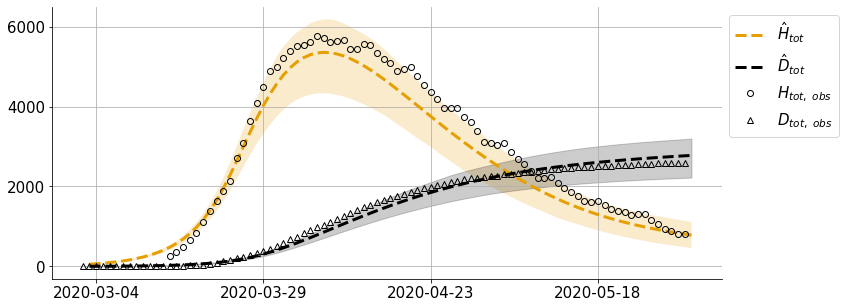

In [14]:
fig,ax = plt.subplots(figsize=(12,5))

ax.plot(dates[40:],out['H_tot'].sum(dim="Nc").mean(dim="draws")[40:],'--')
ax.plot(dates[40:],out['D'].sum(dim="Nc").mean(dim="draws")[40:],'--',color='black')
ax.plot(df_sciensano.index[:-127],df_sciensano['H_tot'][:-127],'o',color='black',mfc='none')
ax.plot(df_deaths.index[60:-94],df_deaths['deceased_hosp'][60:-94].cumsum(axis=0),'^',color='black',mfc='none')
ax.fill_between(dates[40:],out['H_tot'].sum(dim="Nc").quantile(0.95,dim="draws")[40:],out['H_tot'].sum(dim="Nc").quantile(0.05,dim="draws")[40:],alpha=0.2)
ax.fill_between(dates[40:],out['D'].sum(dim="Nc").quantile(0.95,dim="draws")[40:],out['D'].sum(dim="Nc").quantile(0.05,dim="draws")[40:],alpha=0.2,color='black')

# add custom legend
ax.legend(('$\hat{H}_{tot}$', '$\hat{D}_{tot}$',
               '$H_{tot,\ obs}$', '$D_{tot,\ obs}$'),
              loc="upper left", bbox_to_anchor=(1,1))

# limit the number of ticks on the axis
ax = _apply_tick_locator(ax)

# save figure
plt.savefig('../../results/QALYs/model_prediction.pdf',bbox_inches='tight')

## Do a close-up of the number of deaths on June 1st

In [15]:
df_deaths['deceased_hosp'].cumsum(axis=0)[-94]

2600.0

In [16]:
df_deaths_full = pd.read_csv('../../data/raw/sciensano/COVID19BE_MORT_RAW.csv', parse_dates=['DATE'])

In [17]:
age_classes = pd.IntervalIndex.from_tuples([(0,10),(10,20),(20,30),(30,40),(40,50),(50,60),(60,70),(70,80),(80,120)], 
                                           closed='left')
df_deaths_full['age_class'] = pd.cut(df_deaths_full.AGE, bins=age_classes)
df_deaths_full.head()

,ID,DATE,REGION,PLACE,STATUS,STATUS3,AGE,SEX,NEW,age_class
0,10368,2020-03-17,Flanders,Hospital,Confirmed,ConfirmedLab,82.0,NaN,2,"[80, 120)"
1,10367,2020-03-21,Flanders,Hospital,Confirmed,ConfirmedLab,88.0,NaN,2,"[80, 120)"
2,10366,2020-03-22,Flanders,Hospital,Confirmed,ConfirmedLab,93.0,NaN,2,"[80, 120)"
3,10365,2020-03-18,Flanders,Hospital,Confirmed,ConfirmedLab,90.0,NaN,2,"[80, 120)"
4,10364,2020-03-19,Flanders,Hospital,Confirmed,ConfirmedLab,88.0,NaN,2,"[80, 120)"


In [18]:
deaths = df_deaths_full.groupby(by='age_class').apply(lambda x: x[((x.PLACE=='Hospital')&(x.STATUS=='Confirmed')&(x.STATUS3=='ConfirmedLab')&(x.DATE <='2020-06-01'))].age_class.count())

In [19]:
deaths

age_class
[0, 10)         0
[10, 20)        1
[20, 30)        2
[30, 40)       11
[40, 50)       44
[50, 60)      156
[60, 70)      456
[70, 80)      979
[80, 120)    2379
dtype: int64

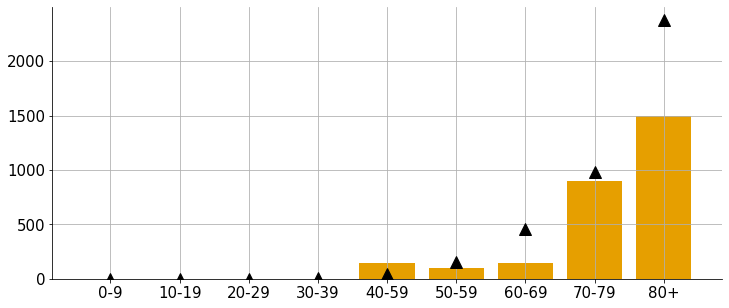

In [20]:
fig,ax = plt.subplots(figsize=(12,5))
age_group=['0-9','10-19','20-29','30-39','40-59','50-59','60-69','70-79','80+']
ax.bar(age_group,out["D"].mean(dim="draws").isel(time=out["time"][-1]))
ax.plot(age_group,deaths,'^',color='black',markersize='12')
plt.show()

## QALY calculations

In [21]:
# Obtain the number of QALYs that would be lost if a person of a given age dies
from covid19model.models.QALY import *

### Quality of life parameters

In [22]:
#Standarized Mortality ratio. It is used to adjust for increased mortality
#due to comorbidities. It modifies l(x), the term in life tables that \n
#corresponds to the number of people per 100000 hab that survives to age x
SMR=1

#Adjustment paramter to account for additional impact on quality of life 
#due to comorbidity
qCM=1

#Disccount rate. It is included due to the time preference. Things in the present
#are valued more than in the future. 5% is standard practice
r=0.03

##Import input data##
#Belgian life table information
#x: Age
#q_x: Probability that someone aged exactly x will die before reaching age x+1
input_life_table=pd.read_csv('../../data/interim/QALYs/Life_table_Belgium_2019.csv',sep=';')

#Belgian EQ-5D QoL Survey data
input_QoL=pd.read_csv('../../data/interim/QALYs/QoL_scores_Belgium_2018_v3.csv',sep=';')

#Calculate and output age-stratified parameters
lost_QALY_pp=get_QALY_parameters(input_life_table,input_QoL,SMR,qCM,r)

### Perform the QALY calculation and add to the xarray output of the model

In [23]:
out = QALY2xarray(out,lost_QALY_pp)

### Visualize number of QALYs lost

In [24]:
sim_time = len(out["time"].values)-1

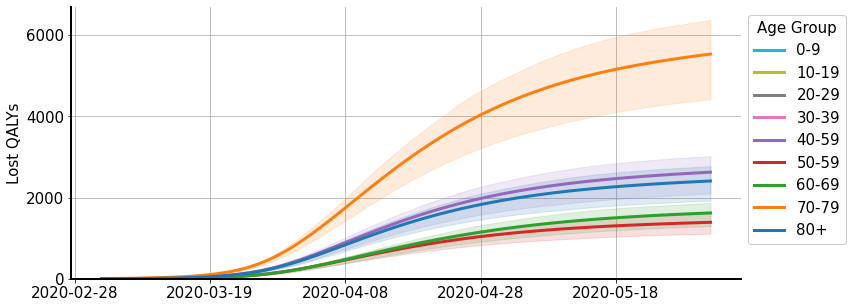

In [25]:
#Plot

Palette=cm.get_cmap('tab10_r', levels).colors
age_group=['0-9','10-19','20-29','30-39','40-59','50-59','60-69','70-79','80+']

fig, ax = plt.subplots(figsize=(12,5))

for i in range(levels):
               
    ax.plot(dates[40:],out['QALYs_lost'].mean(dim="draws")[i][40:],linewidth=3, label=age_group[i],color=Palette[i])
    ax.fill_between(dates[40:],out['QALYs_lost'][40:].quantile(0.05,dim="draws")[i][40:],
                    out['QALYs_lost'].quantile(0.95,dim="draws")[i][40:], alpha = 0.15, color=Palette[i],)
    
#ax.set_xlim(left=50,right=sim_time)
ax.set_ylim(bottom=0)
ax.set_ylabel('Lost QALYs')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.tick_params(labelsize=25)
ax.spines["bottom"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.set_axisbelow(True)
ax.legend(fancybox=True, frameon=True, framealpha=1, fontsize=15,title='Age Group', loc="upper left", bbox_to_anchor=(1,1))  
# limit the number of ticks on the axis
ax = _apply_tick_locator(ax)
# save figure
plt.savefig('../../results/QALYs/QALY_prediction.pdf',bbox_inches='tight')

###  The effect of hospital care reduction vs. COVID-19
+ In the folowing example, the loss of life due to a constant average percentual reduction in regular hospital is calculated and compared with the overall loss of life to Covid-19.
+ The provided function can be used to investigate the effect of time-dependent changes in hospital care as well as reductions in the treatment of different disease categories.

In [26]:
from covid19model.models.QALY import lost_QALY_hospital_care

# Define percentual reduction range
reduction_range=np.linspace(0.02,0.20,100)
# Calculate QALYs lost due to hospital care reduction
lost_hospital=lost_QALY_hospital_care(reduction_range)/365
# Calculate how much QALYs are lost over a time period delta_T
delta_T = sim_time
QALY_indirect = lost_hospital*delta_T
# Extract direct QALY loss from model
QALY_direct_mean = out['QALYs_lost'].mean(dim="draws").sum(dim="Nc").isel(time=sim_time).values
QALY_direct_lower = out['QALYs_lost'].quantile(0.05,dim="draws").sum(dim="Nc").isel(time=sim_time).values
QALY_direct_upper = out['QALYs_lost'].quantile(0.95,dim="draws").sum(dim="Nc").isel(time=sim_time).values
# Calculate ratio
ratio_mean = QALY_direct_mean/QALY_indirect
ratio_upper = QALY_direct_lower/QALY_indirect
ratio_lower = QALY_direct_upper/QALY_indirect

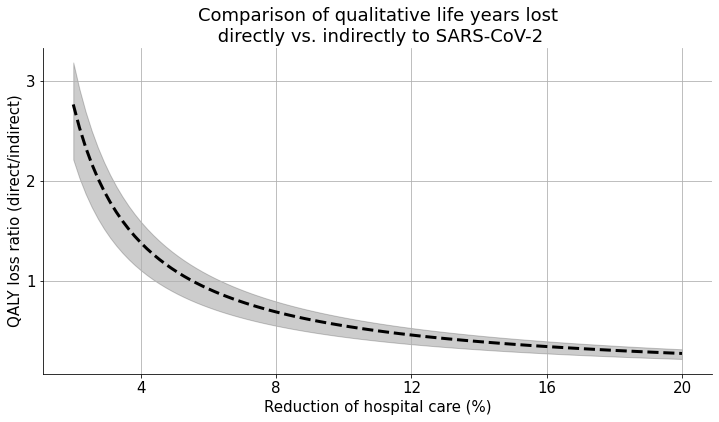

In [27]:
from covid19model.visualization.output import _apply_tick_locator

# Initialize plot
fig,ax = plt.subplots(figsize=(12,6))

# Add lines
ax.plot(reduction_range*100,ratio_mean,'--',color='black')
ax.fill_between(reduction_range*100,ratio_lower,ratio_upper,alpha=0.2,color='black')

# limit the number of ticks on the axis
ax = _apply_tick_locator(ax)

# labels and title
ax.set_xlabel('Reduction of hospital care (%)')
ax.set_ylabel('QALY loss ratio (direct/indirect)')
plt.title('Comparison of qualitative life years lost\n directly vs. indirectly to SARS-CoV-2')

# save figure
plt.savefig('../../results/QALYs/QALYratio.pdf',dpi=300)

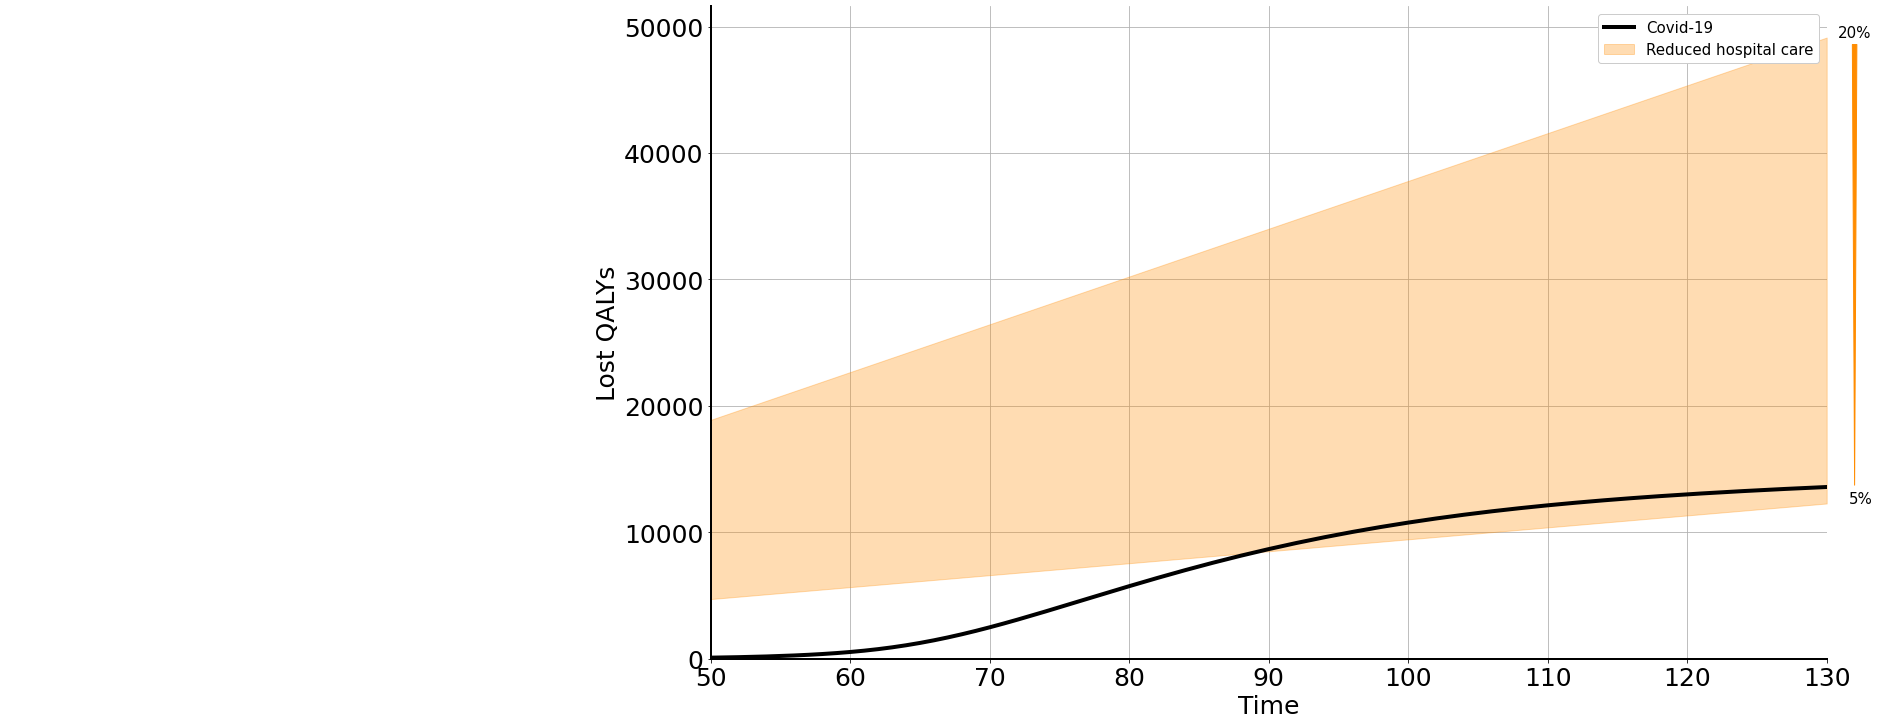

In [28]:
from covid19model.models.QALY import lost_QALY_hospital_care

#Define percentual reduction range
reduction_range=np.linspace(0.05,0.2,200)
#Calculate QALYs lost due to hospital care reduction
#The function output is annualized
lost_hospital=lost_QALY_hospital_care(reduction_range)/365
#Convert results into time series
lost_hospital_time=np.zeros((lost_hospital.size,sim_time+1))
time=np.array(out['QALYs_lost']['time'])
for i in range(sim_time+1):     
    lost_hospital_time[:,i]=time[i]*lost_hospital
    
#Plot
fig, ax = plt.subplots(figsize=(20,12))
ax.plot(out['QALYs_lost'].sum(dim='Nc').mean(dim="draws"),color='k',linewidth=4,label='Covid-19')
ax.fill_between(time, lost_hospital_time[0,:], lost_hospital_time[-1,:],color='darkorange',
            alpha=0.3,label='Reduced hospital care')

ax.set_xlim(left=50,right=sim_time)
ax.set_ylim(bottom=0)

arrow_limit_upper=trans = (ax.transData + ax.transAxes.inverted()).transform((1,lost_hospital_time[-1,-1]))
arrow_limit_lower=trans = (ax.transData + ax.transAxes.inverted()).transform((1,lost_hospital_time[0,-1]))
ax.annotate("{0}%".format(int(reduction_range[-1]*100)), xy=(1.025, arrow_limit_lower[1]+0.025), 
            xycoords='axes fraction', xytext=(1.01, arrow_limit_upper[1]), 
            arrowprops=dict(arrowstyle="wedge", color='darkorange'))

ax.text(1.02,arrow_limit_lower[1],"{0}%".format(int(reduction_range[0]*100)),transform=ax.transAxes)
#Calculate interection point
Intersect_point=np.argwhere(np.diff(np.sign(out['QALYs_lost'].sum(dim='Nc') - lost_hospital_time[0,:]))).flatten()
ax.annotate(("If regular hospital care is reduced\nby {0}%, the loss of life associated with reduced care"  
            "\nwith will be higher than that\nrelated "
            "to Covid-19 during the first\n{1} days.").format(int(reduction_range[0]*100),time[Intersect_point[1]]), 
            xy=(time[Intersect_point[1]], lost_hospital_time[0,Intersect_point[1]]), 
            xytext=(0.55*time[Intersect_point[1]], 1.5*lost_hospital_time[-1,Intersect_point[1]]), 
            arrowprops=dict(color='darkorange'))

ax.set_xlabel('Time',fontsize=25)
ax.set_ylabel('Lost QALYs',fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=25)
ax.spines["bottom"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.set_axisbelow(True)
ax.legend(loc='best', fancybox=True, frameon=True, framealpha=1, fontsize=15)  